In [1]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from datasets.heartdatasets import VinBigDataHeartDataset

import torchvision.transforms as T
from models.fastrcnn import get_model

In [2]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [3]:
def get_vinbigdata_dataframe(path):
    IMG_SIZE = 512
    df = pd.read_csv(path)
    df['x_min'] = IMG_SIZE * df['x_min'] / df['width']
    df['x_max'] = IMG_SIZE * df['x_max'] / df['width']
    df['y_min'] = IMG_SIZE * df['y_min'] / df['height']
    df['y_max'] = IMG_SIZE * df['y_max'] / df['height']
    df = df[df.class_name.eq('Cardiomegaly')]
    return df

In [4]:
from sklearn.model_selection import train_test_split

df = get_vinbigdata_dataframe('./data/vinbigdata/train.csv')
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

#TODO: Check bug with data augmentation
ds_train = VinBigDataHeartDataset(df, './data/vinbigdata/train/', get_transform(train=False))
ds_test = VinBigDataHeartDataset(df, './data/vinbigdata/train/', get_transform(train=False))

In [5]:
ds_train[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4471, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2902, 0.3098, 0.3176,  ..., 0.0353, 0.0196, 0.0000],
          [0.3098, 0.3059, 0.3216,  ..., 0.0392, 0.0235, 0.0000],
          [0.1608, 0.3176, 0.3137,  ..., 0.0431, 0.0235, 0.0039]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4471, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2902, 0.3098, 0.3176,  ..., 0.0353, 0.0196, 0.0000],
          [0.3098, 0.3059, 0.3216,  ..., 0.0392, 0.0235, 0.0000],
          [0.1608, 0.3176, 0.3137,  ..., 0.0431, 0.0235, 0.0039]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4471, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [6]:
ds_train[0][0].shape

torch.Size([3, 512, 512])

In [7]:
from datasets.heartdatasets import CheXpertHeartDataset
import torch

In [8]:
ds_train_no_finding = CheXpertHeartDataset('./data/hand-label/nofinding/','../CheXpert-v1.0-small/train' ,get_transform(train=False), test= True)
ds_train_cardiomegaly = CheXpertHeartDataset('./data/hand-label/cardiomegaly-certain/','../CheXpert-v1.0-small/train' ,get_transform(train=False), test= True)

ds_train_chexpert = torch.utils.data.ConcatDataset([ds_train_no_finding, ds_train_cardiomegaly])
print(len(ds_train_no_finding), len(ds_train_cardiomegaly), len(ds_train_chexpert))
train_ds_chexpert,val_ds_chexpert = torch.utils.data.random_split(ds_train_chexpert, [len(ds_train_chexpert) - 100, 100], generator=torch.Generator().manual_seed(42))



200 200 400


In [9]:
labeled = [x[1]['extra'].replace('/','_',2) for x in ds_train_cardiomegaly]
for idx,i in enumerate(os.listdir('../chexpert-validation/cardiomegaly')):
    if i not in labeled:
        print(idx,i)

print(len(os.listdir('../chexpert-validation/cardiomegaly')))
print(len(labeled))

200
200


In [10]:
labeled = [x[1]['extra'].replace('/','_',2) for x in ds_train_no_finding ]
for idx,i in enumerate(os.listdir('../chexpert-validation/nofinding')):
    if i not in labeled:
        print(idx,i)

print(len(os.listdir('../chexpert-validation/nofinding')))
print(len(labeled))

200
200


In [11]:
print(labeled)

['patient00013_study1_view1_frontal.jpg', 'patient00375_study1_view1_frontal.jpg', 'patient00500_study2_view1_frontal.jpg', 'patient00587_study1_view1_frontal.jpg', 'patient00640_study1_view1_frontal.jpg', 'patient00876_study1_view1_frontal.jpg', 'patient00881_study1_view1_frontal.jpg', 'patient01094_study11_view1_frontal.jpg', 'patient01134_study1_view1_frontal.jpg', 'patient01256_study1_view1_frontal.jpg', 'patient01544_study1_view1_frontal.jpg', 'patient01558_study2_view1_frontal.jpg', 'patient01572_study1_view1_frontal.jpg', 'patient01840_study1_view1_frontal.jpg', 'patient02134_study1_view1_frontal.jpg', 'patient02203_study13_view1_frontal.jpg', 'patient02500_study1_view1_frontal.jpg', 'patient02506_study2_view1_frontal.jpg', 'patient02778_study14_view1_frontal.jpg', 'patient02886_study6_view1_frontal.jpg', 'patient03113_study1_view1_frontal.jpg', 'patient03397_study1_view1_frontal.jpg', 'patient04039_study1_view1_frontal.jpg', 'patient04097_study1_view1_frontal.jpg', 'patient0430

In [12]:
for i in range(10):
    #print(ds_train_chexpert[i][1]['extra'])
    print(val_ds_chexpert[i][1]['extra'])

patient33169/study1/view1_frontal.jpg
patient10398/study3/view1_frontal.jpg
patient14763/study1/view1_frontal.jpg
patient26444/study1/view1_frontal.jpg
patient16357/study1/view1_frontal.jpg
patient06845/study3/view1_frontal.jpg
patient21750/study1/view1_frontal.jpg
patient31070/study2/view1_frontal.jpg
patient02031/study1/view1_frontal.jpg
patient15296/study6/view1_frontal.jpg


In [13]:
len(val_ds_chexpert)

100

In [14]:
ds_train_chexpert[9]

(tensor([[[0.9961, 0.9882, 0.9098,  ..., 0.6667, 0.6902, 0.7608],
          [0.9569, 0.7294, 0.5255,  ..., 0.3216, 0.3765, 0.4745],
          [0.6431, 0.4510, 0.3765,  ..., 0.1765, 0.2196, 0.3804],
          ...,
          [0.4000, 0.2784, 0.2196,  ..., 0.1373, 0.1490, 0.1961],
          [0.5137, 0.3373, 0.2627,  ..., 0.1490, 0.1647, 0.2157],
          [0.5373, 0.4667, 0.3765,  ..., 0.1804, 0.2314, 0.2667]],
 
         [[0.9961, 0.9882, 0.9098,  ..., 0.6667, 0.6902, 0.7608],
          [0.9569, 0.7294, 0.5255,  ..., 0.3216, 0.3765, 0.4745],
          [0.6431, 0.4510, 0.3765,  ..., 0.1765, 0.2196, 0.3804],
          ...,
          [0.4000, 0.2784, 0.2196,  ..., 0.1373, 0.1490, 0.1961],
          [0.5137, 0.3373, 0.2627,  ..., 0.1490, 0.1647, 0.2157],
          [0.5373, 0.4667, 0.3765,  ..., 0.1804, 0.2314, 0.2667]],
 
         [[0.9961, 0.9882, 0.9098,  ..., 0.6667, 0.6902, 0.7608],
          [0.9569, 0.7294, 0.5255,  ..., 0.3216, 0.3765, 0.4745],
          [0.6431, 0.4510, 0.3765,  ...,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(320, 320, 3)
121 175 224 250


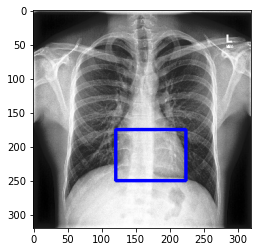

In [15]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.pyplot import figure
import cv2

x0,y0,x1,y1 = ds_train_chexpert[10][1]['boxes'].cpu().numpy()[0].astype(int)
img = ds_train_chexpert[10][0].permute(1,2,0).cpu().numpy()

print(img.shape)
print(x0,y0,x1,y1)
im = cv2.rectangle(img.copy(), (x0,y0) , (x1,y1), (0,0,255), 4)
imshow(im)

In [16]:
print(len(val_ds_chexpert))

ground_truth = {}
for idx in range(len(val_ds_chexpert)):
    image, data = val_ds_chexpert[idx]
    if 'boxes' in data:
        ground_truth[data['extra']] =  data['boxes'][0].cpu().numpy()
        #x0,y0,x1,y1
    #print(x0,y0,x1,y1)

100


In [17]:
ground_truth

{'patient33169/study1/view1_frontal.jpg': array([140.13792, 179.64143, 220.4688 , 218.48273], dtype=float32),
 'patient10398/study3/view1_frontal.jpg': array([158.45856, 169.4896 , 270.12756, 229.95872], dtype=float32),
 'patient14763/study1/view1_frontal.jpg': array([141.46208, 204.8    , 250.48288, 249.3792 ], dtype=float32),
 'patient26444/study1/view1_frontal.jpg': array([136.60704, 203.91711, 245.18623, 251.14464], dtype=float32),
 'patient16357/study1/view1_frontal.jpg': array([115.61711, 190.2344 , 298.34808, 289.5448 ], dtype=float32),
 'patient06845/study3/view1_frontal.jpg': array([161.10706, 170.37248, 276.74835, 249.8208 ], dtype=float32),
 'patient21750/study1/view1_frontal.jpg': array([103.06192, 152.276  , 229.29648, 239.66896], dtype=float32),
 'patient31070/study2/view1_frontal.jpg': array([126.45504, 197.73792, 218.70335, 241.43456], dtype=float32),
 'patient02031/study1/view1_frontal.jpg': array([139.3517 , 179.64192, 253.92975, 258.2096 ], dtype=float32),
 'patient1

In [18]:
import cv2
import torch
import os
import cv2
import torch
import torchvision.transforms as T
from PIL import Image
from models.fastrcnn import get_model

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

def evaluate_image(model, path,device):
    img_loaded = cv2.imread(path, cv2.IMREAD_COLOR)
    img_loaded = get_transform(train=False)(img_loaded)
    model.eval()
    with torch.no_grad():
        prediction = model([img_loaded.to(device)])
        return img_loaded,prediction[0]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)

name = 'modelAFTERPRETRAINING4'
model_params = torch.load(f'./intermediate/heart_weights/{name}.pth')
model.load_state_dict(model_params)

import os
from tqdm import tqdm
import pickle

CHEXPERT_VALIDATION_BASE = './data/chexpert-cardio-nofinding'

paths = os.listdir(CHEXPERT_VALIDATION_BASE)

predictions = {}
for p in tqdm(paths):
    if p.replace('_','/',2) in ground_truth:
        prediction = evaluate_image(model, CHEXPERT_VALIDATION_BASE+'/'+p,device)
        if len(prediction[1]['boxes']) > 0:
            predictions[p.replace('_','/',2)] = ((prediction[1]['boxes'])[0],prediction[0].shape)
    #predictions.append(prediction)

100%|█████████████████████████████████████████████████████████████████████████████| 9547/9547 [00:23<00:00, 401.02it/s]


In [19]:
predictions[list(predictions)[10]]

(tensor([137.5397, 206.4979, 311.0989, 282.6140], device='cuda:0'),
 torch.Size([3, 320, 369]))

In [20]:
errors = []
for p in ground_truth:
    
    if p in predictions:
        pred = predictions[p]
    else:
        print('None')
    truth = ground_truth[p]
    x0,_,x1,_ = truth
    x2,_,x3,_= pred[0].cpu().numpy()
    width = pred[1][2]
    error =abs(((x3-x2)/ width - (x1-x0)/width))
    errors.append(error)
    
    #print('Err',error, x1-x0,x3-x2)
    
errors = np.array(errors)

Err 0.0037703037261963 80.33087 79.124374
Err 0.002537094157562647 111.66901 112.605194
Err 0.02144966125488279 109.0208 102.156906
Err 0.00253124237060548 108.57919 107.769196
Err 0.06986450026240049 182.73097 157.50989
Err 0.04484913730362888 115.6413 132.19063
Err 0.013940382003784224 126.23456 121.773636
Err 0.030863666534423795 92.248314 102.12469
Err 0.03247625177556818 114.57805 102.78917
Err 0.016314983367919922 145.22496 140.00417
Err 0.0134138584136963 105.4896 109.782036
Err 0.03893027305603031 95.779205 108.23689
Err 0.019282477981029778 94.89647 102.0117
Err 0.01300162952032119 107.69641 112.39
Err 0.002779817581176791 136.09663 135.20709
Err 0.0054967403411865234 95.779205 94.02025
Err 0.0008952617645263672 100.130554 100.41704
Err 0.0050895643530425305 162.86438 164.50322
Err 0.001586341857910123 87.05087 86.54324
Err 0.00012869834899903454 105.66912 105.62794
Err 0.009585993076727639 120.05525 116.51802
Err 0.001703023910522461 147.86208 148.40704
Err 0.0083574331226710

In [21]:
len(errors)

100

In [22]:
print('RMSE:', np.sqrt((errors ** 2).sum()/len(errors)))
print('Min:', errors.min())
print('Max:', errors.max())
print('Mean:', errors.mean())
print('Median:', np.median(errors))
print('STD:', errors.std())

RMSE: 0.02614550042426097
Min: 0.00012869834899903454
Max: 0.08355547433876132
Mean: 0.01855517227811203
Median: 0.013028441274595431
STD: 0.01841990157858106


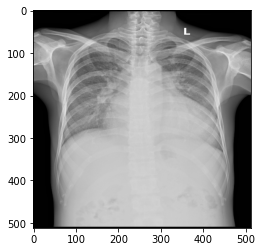

In [23]:
from matplotlib.pyplot import imshow
imshow(ds_train[9][0].permute(1,2,0))